<h1 style="text-align: center">Yelp Rating Prediction</h1>
<hr style="border-top: 1px solid #444">

## Development Environment

### Imports

In [17]:
# imports
from typing import TypedDict, Dict, List
from statistics import mean, stdev
from io import StringIO
from time import time
import sys
import os
import json
import spectra
import math
import pandas
import numpy
import sklearn
import tensorflow
import matplotlib.pyplot as pyplot
from matplotlib.ticker import FuncFormatter
from IPython.core.display import display, HTML
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# store standard out stream
original_stdout = sys.stdout

print(f"Python: {sys.version}")
print(f"Pandas {pandas.__version__}")
print(f"Scikit-Learn {sklearn.__version__}")
print(f"Tensor Flow Version: {tensorflow.__version__} (Keras Version: {tensorflow.keras.__version__})")

Python: 3.8.5 (tags/v3.8.5:580fbb0, Jul 20 2020, 15:57:54) [MSC v.1924 64 bit (AMD64)]
Pandas 1.1.2
Scikit-Learn 0.23.2
Tensor Flow Version: 2.3.0 (Keras Version: 2.4.0)


### Configure PRNG Seed

In [18]:
PRNG_SEED = 42
numpy.random.seed(PRNG_SEED)
tensorflow.random.set_seed(PRNG_SEED)

<hr style="border-top: 1px solid #444">

# I. Data Importation

## Dataset Location

In [19]:
!dir /b "./data/"

file_businesses = r"data/yelp_academic_dataset_business.json"
file_user_reviews = r"data/yelp_academic_dataset_review.json"

Dataset_User_Agreement.pdf
yelp_academic_dataset_business.json
yelp_academic_dataset_checkin.json
yelp_academic_dataset_review.json
yelp_academic_dataset_tip.json
yelp_academic_dataset_user.json


## Import Yelp Businesses

In [20]:
# metrics
start_time = time()

# business data structure
class Business(TypedDict):
    business_id: str
    review_count: int
    stars: float

# businesses indexed by business_id (i.e. {business['business_id']: Business}
businesses_by_id: Dict[str, Business] = {}

# parse all businesses
with open(file_businesses, 'r', encoding='utf-8') as file:
    # iterate over newline-delimited JSON records
    record: str
    for record in file:
        # parse JSON record
        business: Business = json.loads(record)
        # map Business by business_id
        businesses_by_id[business['business_id']] = business

# metrics
print(f"Imported {len(businesses_by_id):,} distinct businesses in {time() - start_time:.6f} seconds")

Imported 209,393 distinct businesses in 4.467366 seconds


## Import User Reviews

In [21]:
# metrics
start_time = time()

# user review data structure
class UserReview(TypedDict):
    business_id: str
    text: str

# user reviews indexed by business_id (i.e. {business_id: UserReview[]})
business_review_texts: Dict[str, List[str]] = {
    business_id: []
    for business_id in businesses_by_id.keys()
}

# parse user reviews
with open(file_user_reviews, 'r', encoding='utf-8') as file:
    # iterate over newline-delimited JSON records
    record: str
    for record in file:
        # parse JSON record
        review: UserReview = json.loads(record)
        # map user review by business_id
        business_review_texts[review['business_id']].append(review["text"])

# metrics
print(f"Imported {sum([len(reviews) for reviews in business_review_texts.values()]):,} user reviews in {time() - start_time:.6f} seconds")

Imported 8,021,122 user reviews in 113.376799 seconds


<hr style="border-top: 1px solid #444">

## II. Dataset Visualizations

### Star Rating Distribution

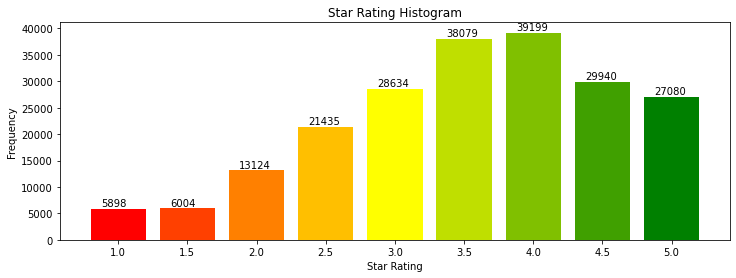

Rendered graphic in 0.554757 seconds


In [22]:
# metrics
start_time = time()

pyplot.figure(figsize=(12, 4))
pyplot.title("Star Rating Histogram")
pyplot.xlabel("Star Rating")
pyplot.ylabel("Frequency")
star_color = spectra.scale(['red', 'yellow', 'green'])
for star_rating, frequency in pandas.DataFrame(businesses_by_id.values(), columns=['stars'])['stars'].value_counts().sort_index().items():
    pyplot.bar(str(star_rating), frequency, color=star_color((star_rating - 1)/ 4).hexcode)
    pyplot.text(star_rating * 2 - 2.25, frequency + 400, frequency)
pyplot.show()

# metrics
print(f"Rendered graphic in {time() - start_time:.6f} seconds")

### Review Count Distribution

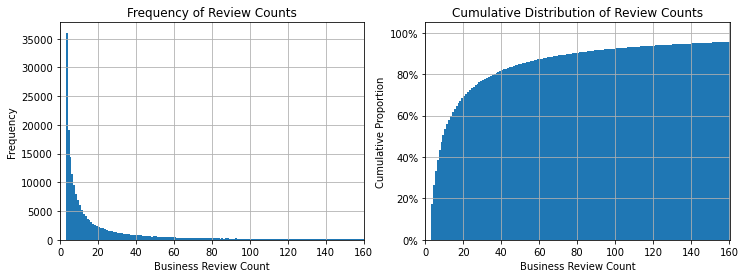

Rendered graphic in 43.460822 seconds


In [23]:
# metrics
start_time = time()

review_counts = [business['review_count'] for business in businesses_by_id.values()]
figure = pyplot.figure(figsize=(12, 4))

axes = figure.add_subplot(1, 2, 1)
axes.set_title("Frequency of Review Counts")
axes.set_xlabel("Business Review Count")
axes.axis(xmin=0, xmax=mean(review_counts) + stdev(review_counts))
axes.set_ylabel("Frequency")
axes.grid(True)
axes.hist(review_counts, bins = list(range(0, max(review_counts))))

## Cumulative
axes = figure.add_subplot(1, 2, 2)
axes.set_title("Cumulative Distribution of Review Counts")
axes.set_xlabel("Business Review Count")
axes.axis(xmin=0, xmax=mean(review_counts) + stdev(review_counts))
axes.set_ylabel("Cumulative Proportion")
axes.yaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))
axes.grid(True)
pyplot.hist(review_counts, bins=list(range(0, max(review_counts))), cumulative=True, density=True)

pyplot.show()

# metrics
print(f"Rendered graphic in {time() - start_time:.6f} seconds")

<hr style="border-top: 1px solid #444">

## III. Data Preprocessing

### Filter Businesses with Less than 15 Reviews

In [24]:
# minimum business['review_count'] required to be selected for training
MINIMUM_REVIEW_COUNT = 15

selected_businesses = [business for business in businesses_by_id.values() if MINIMUM_REVIEW_COUNT <= business['review_count']]

print(f"Selected {len(selected_businesses):,} businesses (filtered {len(businesses_by_id) - len(selected_businesses):,})")

Selected 80,355 businesses (filtered 129,038)


### Data Partitioning: Training, Validation, and Testing

In [25]:
# partition size constants
TRAINING_SIZE = 10_000
VALIDATE_SIZE = 1_000
TESTING_SIZE = 10_000

# metrics
start_time = time()

# perform partitions
partitions = {}
partitions['train'], _ = train_test_split(
    # select all businesses that are greater than or equal to MINIMUM_REVIEW_COUNT
    selected_businesses,
    # partition proportions
    train_size=TRAINING_SIZE,
    shuffle=True,
    # PRNG seed for deterministic behaviour
    random_state=PRNG_SEED,
)
partitions['validate'], partitions['test'] = train_test_split(
    # select all businesses not in partitions['train']
    [
        businesses_by_id[business_id]
        for business_id in set([business['business_id'] for business in selected_businesses]).difference(set([business['business_id'] for business in partitions['train']]))
    ],
    # partition proportions
    train_size=VALIDATE_SIZE,
    test_size=TESTING_SIZE,
    shuffle=True,
    # PRNG seed for deterministic behaviour
    random_state=PRNG_SEED,
)

# metrics
print(f"Partitioned {len(businesses_by_id):,} businesses into { {category: len(partition) for category, partition in partitions.items()}} in {time() - start_time:.6f} seconds")
print(f"Remaining unused businesses: {len(businesses_by_id) - sum([len(partition) for partition in partitions.values()]):,}")

Partitioned 209,393 businesses into {'train': 10000, 'validate': 1000, 'test': 10000} in 0.405349 seconds
Remaining unused businesses: 188,393


### Input Features: Preprocess Review Texts using TF-IDF Vectorization

In [26]:
# metrics
start_time = time()

# construct vectorizer
vectorizer: TfidfVectorizer = TfidfVectorizer(
    # maximum word features
    max_features=1500,
    # prune english stop words
    stop_words='english',
)

# construct corpus partitions
tf_input = {
    category: getattr(vectorizer, 'fit_transform' if category == 'train' else 'transform')
              (['\n'.join(business_review_texts[business['business_id']]) for business in partition])
              .toarray()
    for category, partition in partitions.items()
}

# metrics
print(f"Word features cardinality: {len(vectorizer.get_feature_names()):,}")
print(f"Word features: {vectorizer.get_feature_names()}")
print(f"IDF Vectorized {sum([len(matrix) for matrix in tf_input.values()]):,} businesses review texts in {time() - start_time:.6f} seconds")
print()
print(f"Training Shape: {tf_input['train'].shape}")
print(f"Validate Shape: {tf_input['validate'].shape}")
print(f"Testing Shape: {tf_input['test'].shape}")

Word features cardinality: 1,500
Word features: ['00', '10', '100', '11', '12', '13', '14', '15', '16', '18', '20', '24', '25', '2nd', '30', '35', '40', '45', '50', '60', '95', '99', 'able', 'absolute', 'absolutely', 'access', 'accommodating', 'actual', 'actually', 'add', 'added', 'addition', 'additional', 'affordable', 'afternoon', 'ago', 'agreed', 'ahead', 'air', 'airport', 'alcohol', 'allowed', 'alright', 'amazing', 'ambiance', 'ambience', 'american', 'annoying', 'answer', 'answered', 'anymore', 'anyways', 'apart', 'apartment', 'app', 'apparently', 'appetizer', 'appetizers', 'apple', 'appointment', 'appreciate', 'appreciated', 'area', 'areas', 'aren', 'aria', 'arizona', 'arrive', 'arrived', 'art', 'asada', 'asian', 'ask', 'asked', 'asking', 'ate', 'atmosphere', 'attention', 'attentive', 'attitude', 'authentic', 'available', 'average', 'avocado', 'avoid', 'away', 'awesome', 'awful', 'awhile', 'ayce', 'az', 'baby', 'bacon', 'bad', 'bag', 'baked', 'bakery', 'banana', 'bar', 'barely', '

### Output Features: Select Star Rating

In [27]:
tf_output = {
    category: numpy.array([[business['stars']] for business in partition])
    for category, partition in partitions.items()
}

print(f"Training Shape: {tf_output['train'].shape}")
print(f"Validate Shape: {tf_output['validate'].shape}")
print(f"Testing Shape: {tf_output['test'].shape}")

Training Shape: (10000, 1)
Validate Shape: (1000, 1)
Testing Shape: (10000, 1)


<hr style="border-top: 1px solid #444">

# IV. Model Training

## Build Model

In [28]:
# build model
model = Sequential(
    [
        Dense(64, input_dim=tf_input['train'].shape[1]),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(1)
    ],
    name="yelp_regression"
)
# set optimizer for gradient descent
model.compile(loss='mean_squared_error', optimizer='sgd', metrics=['mse'])

# print model summary
model.summary()

Model: "yelp_regression"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                96064     
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 98,689
Trainable params: 98,689
Non-trainable params: 0
_________________________________________________________________


## Train Model

In [29]:
# metrics
start_time = time()

# replace standard out for intercepting model training logs
sys.stdout = captured_stdout = StringIO()

try:
    # make temporary directory for saved model
    if not os.path.exists("temp"):
        os.mkdir("temp")

    # perform model training
    model.fit(
        # training data
        tf_input['train'], tf_output['train'],
        # use test data to validate losses, but not for training
        validation_data=(tf_input['validate'], tf_output['validate']),
        callbacks=[
            # patience: number of epochs with no improvement after which training will be stopped
            EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=50, mode='auto', verbose=0),
            # save best model from all epochs
            ModelCheckpoint(filepath="temp/model_best_weights.hdf5", save_best_only=True, verbose=0)
        ],
        verbose=2,
        epochs=1000,
    )
finally:
    # restore standard out
    sys.stdout = original_stdout

# metrics
print(f"Model trained in {time() - start_time:.6f} seconds")
# noinspection PyTypeChecker
display(HTML(f'\
    <details>\
        <summary><b>Training Details</b></summary>\
        <sub><sup>\
            {"<br>".join(captured_stdout.getvalue().splitlines())}\
        </sup></sub>\
    </details>\
'))

Model trained in 119.387771 seconds


<hr style="border-top: 1px solid #444">

# V. Model Testing

## Model Predictions

In [30]:
# metrics
start_time = time()

# load best model for prediction
model.load_weights("temp/model_best_weights.hdf5")

# compute predicted ratings for test dataset
predicted = model.predict(tf_input['test'])
# map predictions to the nearest half-star
predicted_rounded = numpy.array([min(round(prediction * 2) / 2, 5) for prediction in predicted.flatten()])

# metrics
print(f"Predicted {len(tf_input['test']):,} business ratings in {time() - start_time:.6f} seconds")

Predicted 10,000 business ratings in 0.812684 seconds


## Error Scoring (MSE/RSME)

In [31]:
mse_score = sklearn.metrics.mean_squared_error(predicted, tf_output['test'])
mse_rounded_score = sklearn.metrics.mean_squared_error(predicted_rounded, tf_output['test'])

pandas.DataFrame(
    [
        [mse_score, mse_rounded_score],
        numpy.sqrt([mse_score, mse_rounded_score])
    ],
    columns=["Continuous", "Discrete"],
    index=["MSE", "RSME"]
)

,Continuous,Discrete
MSE,0.087443,0.105975
RSME,0.295707,0.325538


## Lift Chart Visualization

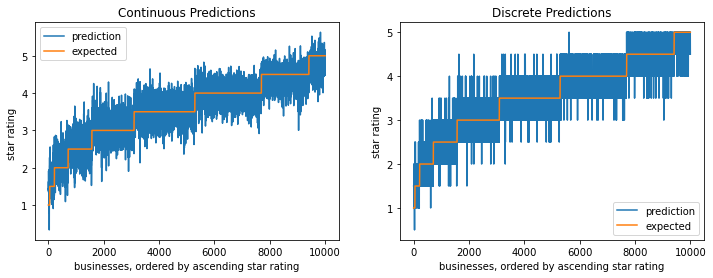

In [32]:
figure = pyplot.figure(figsize=(12, 4))

axes = figure.add_subplot(1, 2, 1)
axes.set_title("Continuous Predictions")
axes.set_xlabel("businesses, ordered by ascending star rating")
axes.set_ylabel("star rating ")
table = pandas.DataFrame({'predicted': predicted.flatten(), 'y': tf_output['test'].flatten()})
table.sort_values(by=['y'], inplace=True)
axes.plot(table['predicted'].tolist(), label="prediction")
axes.plot(table['y'].tolist(), label="expected")
axes.legend()

axes = figure.add_subplot(1, 2, 2)
axes.set_title("Discrete Predictions")
axes.set_xlabel("businesses, ordered by ascending star rating")
axes.set_ylabel("star rating")
table = pandas.DataFrame({'predicted': predicted_rounded.flatten(), 'y': tf_output['test'].flatten()})
table.sort_values(by=['y'], inplace=True)
axes.plot(table['predicted'].tolist(), label="prediction")
axes.plot(table['y'].tolist(), label="expected")
axes.legend()

pyplot.show()